In [1]:
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datasets import Dataset
import torch

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

/home/monsh/anaconda3/envs/lawbuddy/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name = "clicknext/phayathaibert"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at clicknext/phayathaibert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Clean

In [29]:
import re

def remove_outlier_long_text(**kwargs):
    dataframe = kwargs['df'].copy()
    dataframe['length'] = dataframe['text'].apply(lambda x: len(x))
    dataframe = dataframe[dataframe['length'] <= 500]
    # Remove length column
    dataframe = dataframe.drop('length', axis=1)
    return dataframe

def remove_emoji(**kwargs) -> str:
    # text = kwargs['text']
    def _remove(text):
        # Emoji pattern: Matches all characters in Unicode Emoji ranges
        emoji_pattern = re.compile(
            "[\U0001F600-\U0001F64F"  # Emoticons
            "\U0001F300-\U0001F5FF"  # Symbols & Pictographs
            "\U0001F680-\U0001F6FF"  # Transport & Map Symbols
            "\U0001F1E0-\U0001F1FF"  # Flags (iOS)
            "\U00002702-\U000027B0"  # Dingbats
            "\U000024C2-\U0001F251"  # Enclosed characters
            "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)

    dataframe = kwargs['df'].copy()
    dataframe['text'] = dataframe['text'].apply(lambda x: _remove(x))
    return dataframe

def filter_text_length(**kwargs):
    dataframe = kwargs['df'].copy()
    dataframe = dataframe[dataframe['text'].apply(lambda x: len(x) > 0)]
    return dataframe

def clean_data_pipeline(df, pipelines):
    dataframe = df.copy()
    print("Before cleaning:", dataframe.shape)
    for i, pipeline in enumerate(pipelines):
        dataframe = pipeline(df=dataframe)
        print("After pipeline", i, ":", dataframe.shape)

    return dataframe

In [113]:
train_df = pd.read_csv('/home/monsh/works/product-comments-qa/data/labelv1.csv')
val_df = pd.read_csv('../data/test_data.csv')
no = pd.read_csv('../data/no_label.csv')

total = pd.concat([train_df, val_df, no])

pipelines = [remove_outlier_long_text, remove_emoji, filter_text_length]

train_df = clean_data_pipeline(train_df, pipelines=pipelines)
val_df = clean_data_pipeline(val_df, pipelines=pipelines)
total_cleaned = clean_data_pipeline(total, pipelines=pipelines)

Before cleaning: (36919, 7)
After pipeline 0 : (36914, 7)
After pipeline 1 : (36914, 7)
After pipeline 2 : (36846, 7)
Before cleaning: (5468, 8)
After pipeline 0 : (5467, 8)
After pipeline 1 : (5467, 8)
After pipeline 2 : (5461, 8)
Before cleaning: (55468, 9)
After pipeline 0 : (55458, 8)
After pipeline 1 : (55458, 8)
After pipeline 2 : (55384, 8)


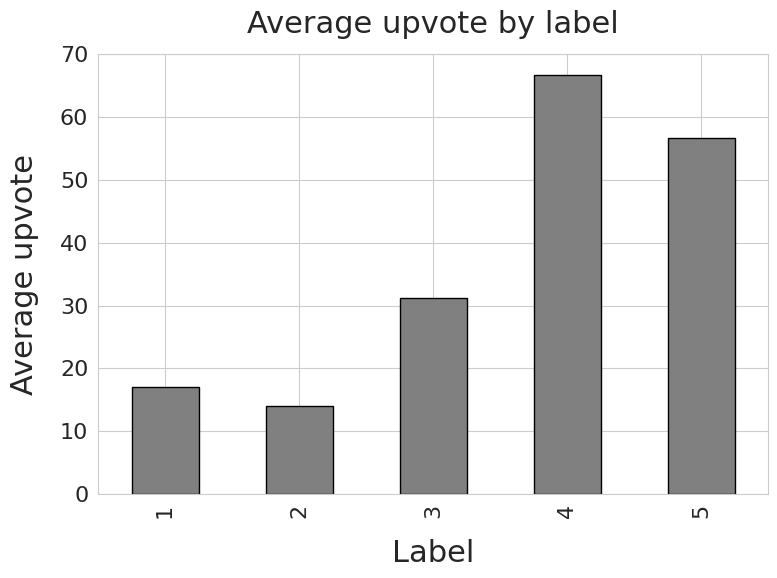

In [92]:
# .plot(kind='bar')
plt.figure(figsize=(8, 6))
plt.rcParams.update({
    # 'font.size': 14,          # Default text size
    'axes.titlesize': 22,     # Title size
    'axes.labelsize': 22,     # Axis labels
    'xtick.labelsize': 16,    # X-axis tick labels
    'ytick.labelsize': 16,    # Y-axis tick labels
    # 'legend.fontsize': 12     # Legend text
})

d = train_df.groupby('label')['upvote'].mean()
d.plot(kind='bar', color="gray", edgecolor='black')
plt.title('Average upvote by label', pad=15)
plt.xlabel('Label', labelpad=15)
plt.ylabel('Average upvote', labelpad=15)
plt.tight_layout()
plt.show()

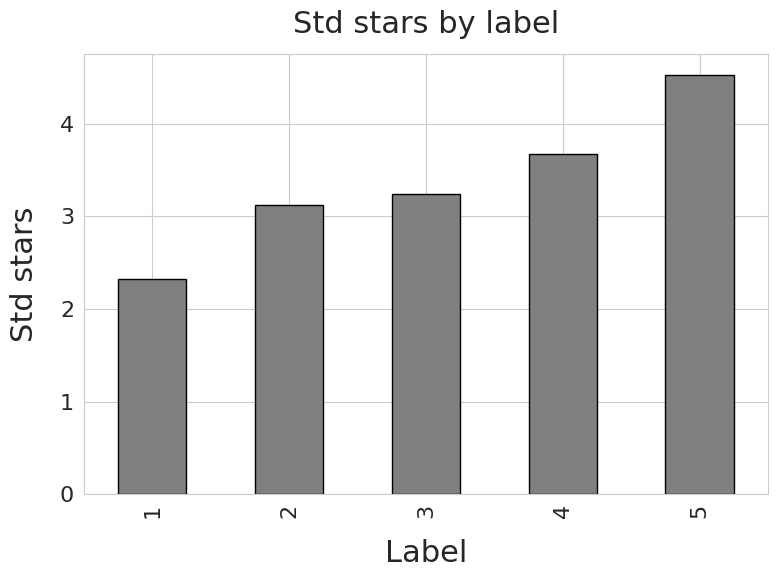

In [93]:
# .plot(kind='bar')
plt.figure(figsize=(8, 6))
plt.rcParams.update({
    # 'font.size': 14,          # Default text size
    'axes.titlesize': 22,     # Title size
    'axes.labelsize': 22,     # Axis labels
    'xtick.labelsize': 16,    # X-axis tick labels
    'ytick.labelsize': 16,    # Y-axis tick labels
    # 'legend.fontsize': 12     # Legend text
})

d = train_df.groupby('label')['star'].mean()
d.plot(kind='bar', color="gray", edgecolor='black')
plt.title('Std stars by label', pad=15)
plt.xlabel('Label', labelpad=15)
plt.ylabel('Std stars', labelpad=15)
plt.tight_layout()
plt.show()

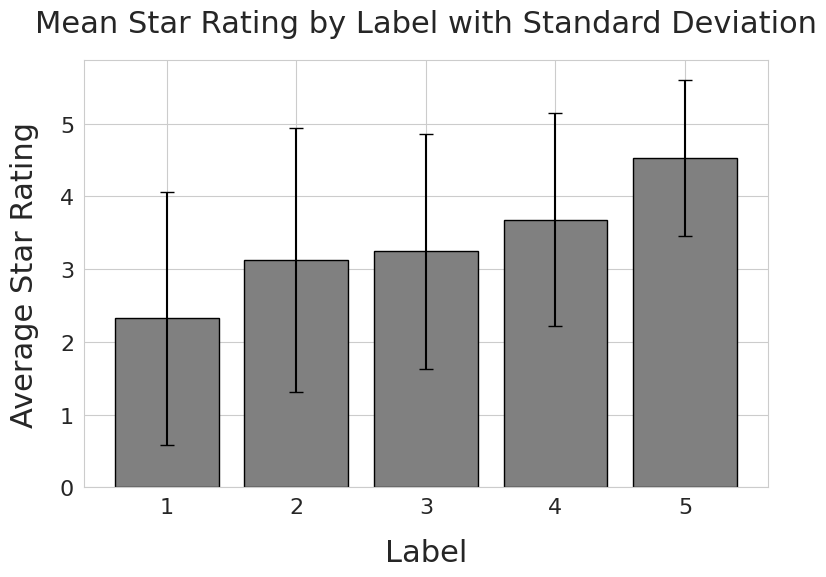

In [94]:
import matplotlib.pyplot as plt

# Grouping the data
means = train_df.groupby('label')['star'].mean()
stds = train_df.groupby('label')['star'].std()

# Plot the mean with error bars for standard deviation
plt.figure(figsize=(8, 6))
plt.bar(means.index, means, yerr=stds, color='gray', edgecolor='black', capsize=5)

# Add labels and title with padding
plt.title('Mean Star Rating by Label with Standard Deviation', pad=20)
plt.xlabel('Label', labelpad=15)
plt.ylabel('Average Star Rating', labelpad=15)

# Adjust layout
plt.tight_layout()
plt.show()

In [96]:
def preprocess_train(examples):
   input_ids = tokenizer(examples['text'], padding="max_length", max_length=72, truncation=True)
   return input_ids

def preprocess_val(examples):
   input_ids = tokenizer(examples['text'], padding="max_length", max_length=72, truncation=True)
   return input_ids

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

tokenized_train = train_dataset.map(preprocess_train,
    remove_columns=["__index_level_0__", "link", "name", "category", "upvote", "star"],
    batched=True)
tokenized_test  = val_dataset.map(preprocess_val,
    remove_columns=["__index_level_0__", "link", "name", "category", "upvote", "star", "ai_predict"],
    batched=True)

Map:   0%|          | 0/36846 [00:00<?, ? examples/s]

Map: 100%|██████████| 5461/5461 [00:00<00:00, 41422.02 examples/s]


In [116]:
eiei = total_cleaned.copy()
eiei['tokens'] = eiei['text'].apply(lambda x: len(tokenizer(x)['input_ids']))

eiei[eiei['tokens'] > 200]

,name,text,category,link,upvote,star,label,ai_predict,tokens
31971,LinkedIn,ะมะมสสเพานะสนะยสะนย ะใะมะฝวะวบ มะะาะสาสะสพมสสะ...,Social,https://play.google.com/store/apps/details?id=...,2,5,1.0,NaN,368
15,DramaBox – สตรีมละครสั้น,สเมเสาเสดสดสสดสดสดาเสเสสดสดสดสดสสดสดสดสดสดสดสส...,Entertainment,https://play.google.com/store/apps/details?id=...,0,5,NaN,NaN,308


In [97]:
import numpy as np
import evaluate

def compute_metrics(eval_pred):
   load_accuracy = evaluate.load("accuracy")

   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]

   return {"accuracy": accuracy}

In [98]:
from transformers import TrainingArguments, Trainer

repo_name = "../models/v1"

LEARNING_RATE = 2e-5
BATCH_SIZE = 48
EPOCHS = 20

training_args = TrainingArguments(
    output_dir=repo_name,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    metric_for_best_model="accuracy",
    load_best_model_at_end=True,
    logging_steps=10,
    weight_decay=0.01,
)

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   compute_metrics=compute_metrics,
)

/home/monsh/anaconda3/envs/lawbuddy/lib/python3.11/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_11885/4107408960.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [100]:
tokenized_train

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 36846
})

In [99]:
trainer.train()

../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [1,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [10,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [16,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [23,0,0] Assertion `t >= 0 && t < n_classes` failed.


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
